# Jupyter notebook analyzing synaptic properties of GluA1 in 2024.08 PV-GFP dataset

Last edited by MES on 9/1/24

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy import stats
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [4]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/2024.08_PV-GFP_GluA1/'

In [5]:
filenames = os.listdir(parentdir)
csvs = [filename for filename in filenames if filename.endswith('csv')]

In [6]:
csvs

['ca1_selectedvsunselected_lmer_pvals.csv',
 'ssc_selectedvsunselected_lmer_pvals.csv']

In [7]:
mats = [filename for filename in filenames if filename.endswith('mat')]

In [8]:
mats

['analyzed_data_nofilt_20240830.mat',
 'analyzed_data_20240819.mat',
 'analyzed_data_20240818.mat',
 'analyzed_data_20240820.mat']

In [9]:
matfile = sio.loadmat('analyzed_data_nofilt_20240830.mat',squeeze_me=True)

In [10]:
sorted(matfile.keys())

['__globals__', '__header__', '__version__', 'data']

In [11]:
matdata = matfile['data']

In [12]:
matdata

array((array(['PVGFP-HPC-GluA1-M1-002-01_pp_syn1',
       'PVGFP-HPC-GluA1-M1-002-01_pp_syn2',
       'PVGFP-HPC-GluA1-M1-002-01_pp_syn3', ..., array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64)], dtype=object), array([7.24391766e-06, 2.77683510e-05, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([347.        , 444.69565217,   0.        , ...,   0.        ,
         0.        ,   0.        ]), array([1, 1, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([1.4020202 , 9.95910419, 0.        , ..., 0.        , 0.        ,
       0.        ])),
      dtype=[('names', 'O'), ('total_vol', 'O'), ('mean_int', 'O'), ('npuncta', 'O'), ('selected_tf', 'O'), ('mean_int_refnorm', 'O')])

In [13]:
names = matdata['names'].item().tolist()

In [14]:
vols = matdata['total_vol'].item()
vols = np.reshape(vols, (vols.shape[0],1))

In [15]:
ints = matdata['mean_int'].item()
ints = np.reshape(ints, (ints.shape[0],1))

In [16]:
ns = matdata['npuncta'].item()
ns = np.reshape(ns, (ns.shape[0],1))

In [17]:
ints_refnorm = matdata['mean_int_refnorm'].item()
ints_refnorm = np.reshape(ints_refnorm, (ints_refnorm.shape[0],1))

In [18]:
selected_tfs = matdata['selected_tf'].item()
selected_tfs = np.reshape(selected_tfs, (selected_tfs.shape[0],1))

In [19]:
data_array = np.concatenate((vols,ints,ints_refnorm,ns,selected_tfs), axis=1)

In [20]:
data_array.shape

(46201, 5)

In [21]:
data = pd.DataFrame(data_array,index=names,
                    columns=['target_vol','target_meanint','target_meanint_refnorm','target_npuncta','selected_tf'])

In [22]:
data.tail(10)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0


In [23]:
data = data[data.index != '[]']

In [24]:
data

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
PVGFP-HPC-GluA1-M1-002-01_pp_syn1,0.000007,347.000000,1.402020,1.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn2,0.000028,444.695652,9.959104,1.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn3,0.000000,0.000000,0.000000,0.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn4,0.000011,385.111111,3.787978,1.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn5,0.000453,390.869333,141.074110,2.0,0.0
...,...,...,...,...,...
PVGFP-SSC-GluA1-M2-001-13_pp_syn922,0.000255,216.426540,24.225995,2.0,0.0
PVGFP-SSC-GluA1-M2-001-13_pp_syn923,0.000000,0.000000,0.000000,0.0,0.0
PVGFP-SSC-GluA1-M2-001-13_pp_syn924,0.000000,0.000000,0.000000,0.0,0.0
PVGFP-SSC-GluA1-M2-001-13_pp_syn925,0.000558,294.859307,164.126506,1.0,0.0


In [25]:
data.shape

(45274, 5)

In [26]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
PVGFP-HPC-GluA1-M1-002-01_pp_syn1,0.000007,347.000000,1.402020,1.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn2,0.000028,444.695652,9.959104,1.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn3,0.000000,0.000000,0.000000,0.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn4,0.000011,385.111111,3.787978,1.0,0.0
PVGFP-HPC-GluA1-M1-002-01_pp_syn5,0.000453,390.869333,141.074110,2.0,0.0


In [27]:
#How many synapses were selected?
data['selected_tf'].value_counts()

selected_tf
0.0    44346
1.0      928
Name: count, dtype: int64

## 1. Add metadata

In [28]:
samples = []
regions = []
roi_fulls = []
fovs = [] 
syns = []
prots = []

for idx,row in data.iterrows():
    splits = idx.split("_")
    splits2 = splits[0].split("-")
    #print(splits)
    region = splits2[1]
    prot = 'GluA1'
    sample = splits2[3]
    fov = splits2[4] + "-" + splits2[5]
    syn = splits[2]

    roi_full = sample+"_"+prot+"_"+fov
    
    samples.append(sample)
    regions.append(region)
    roi_fulls.append(roi_full)
    fovs.append(fov)
    syns.append(syn)
    prots.append(prot)

In [29]:
unique(samples)

['M2', 'M1']

In [30]:
unique(regions)

['SSC', 'HPC']

In [31]:
data['sample'] = samples
data['region'] = regions
data['roi_full'] = roi_fulls
data['fov'] = fovs
data['syn'] = syns
data['prot'] = prots

In [32]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot
PVGFP-HPC-GluA1-M1-002-01_pp_syn1,0.000007,347.000000,1.402020,1.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn1,GluA1
PVGFP-HPC-GluA1-M1-002-01_pp_syn2,0.000028,444.695652,9.959104,1.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn2,GluA1
PVGFP-HPC-GluA1-M1-002-01_pp_syn3,0.000000,0.000000,0.000000,0.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn3,GluA1
PVGFP-HPC-GluA1-M1-002-01_pp_syn4,0.000011,385.111111,3.787978,1.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn4,GluA1
PVGFP-HPC-GluA1-M1-002-01_pp_syn5,0.000453,390.869333,141.074110,2.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn5,GluA1


In [33]:
data.shape

(45274, 11)

In [34]:
selected_yns = []
for idx,row in data.iterrows():
    if row['selected_tf']:
        selected_yns.append('selected')
    else:
        selected_yns.append('unselected')

In [35]:
data['group']=selected_yns

# Test for statistically significant differences in these properties between synapse types

In [36]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [37]:
list(data)

['target_vol',
 'target_meanint',
 'target_meanint_refnorm',
 'target_npuncta',
 'selected_tf',
 'sample',
 'region',
 'roi_full',
 'fov',
 'syn',
 'prot',
 'group']

In [38]:
#approximate new alpha?
0.05 / (4*4)

0.003125

In [39]:
unadjusted_pvals = []
zscores = []

## 1. SSC

In [40]:
data_ctx = data[data['region']=='SSC']

In [41]:
data_ctx.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group
PVGFP-SSC-GluA1-M1-000-05_(steps1-36)_pp_syn1,0.000117,310.257732,21.208598,1.0,0.0,M1,SSC,M1_GluA1_000-05,000-05,pp,GluA1,unselected
PVGFP-SSC-GluA1-M1-000-05_(steps1-36)_pp_syn2,0.000292,303.260331,45.526675,1.0,0.0,M1,SSC,M1_GluA1_000-05,000-05,pp,GluA1,unselected
PVGFP-SSC-GluA1-M1-000-05_(steps1-36)_pp_syn3,0.000289,307.891213,73.733467,6.0,0.0,M1,SSC,M1_GluA1_000-05,000-05,pp,GluA1,unselected
PVGFP-SSC-GluA1-M1-000-05_(steps1-36)_pp_syn4,0.000099,271.182927,21.464286,3.0,0.0,M1,SSC,M1_GluA1_000-05,000-05,pp,GluA1,unselected
PVGFP-SSC-GluA1-M1-000-05_(steps1-36)_pp_syn5,0.000487,274.645161,50.218693,4.0,0.0,M1,SSC,M1_GluA1_000-05,000-05,pp,GluA1,unselected


In [42]:
data_ctx['prot'].value_counts()

prot
GluA1    19975
Name: count, dtype: int64

### 2. GluA1

In [43]:
data_ctx_a1 = data_ctx[data_ctx['prot']=='GluA1']

In [44]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a1, groups=data_ctx_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   target_vol 
No. Observations:   19975     Method:               REML       
No. Groups:         22        Scale:                0.0000     
Min. group size:    401       Log-Likelihood:       118688.7988
Max. group size:    1117      Converged:            Yes        
Mean group size:    908.0                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  43.780 0.000  0.001  0.001
group[T.unselected] -0.001    0.000 -32.532 0.000 -0.001 -0.001
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [45]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.0
3.7840471236306734e-232


In [46]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a1, groups=data_ctx_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  19975   Method:             REML                  
No. Groups:        22      Scale:              6039.6696             
Min. group size:   401     Log-Likelihood:     -115328.4565          
Max. group size:   1117    Converged:          Yes                   
Mean group size:   908.0                                             
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            144.703    4.787  30.225 0.000  135.320  154.086
group[T.unselected] -108.357    3.683 -29.418 0.000 -115.576 -101.138
Group Var            212.611    0.870                                



In [47]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.1029170829961848e-200
3.2193296715060316e-190


#### Compile p-values

In [48]:
pvals_df_index = [
      'GluA1_vol',
    'GluA1_meanint_refnorm'
]

In [49]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [50]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [51]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ssc_selectedvsunselected_lmer_pvals.csv')

In [52]:
prots = unique(data['prot'])

In [53]:
prots

['GluA1']

In [54]:
values = ['target_vol','target_meanint_refnorm']

In [55]:
group_colors = ['blue','red']

In [56]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA1_vol,3.784047e-232,-32.532001,7.568094e-232,True
GluA1_meanint_refnorm,3.219330e-190,-29.417999,3.219330e-190,True


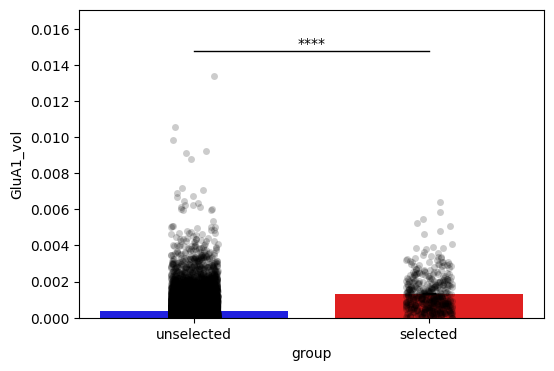

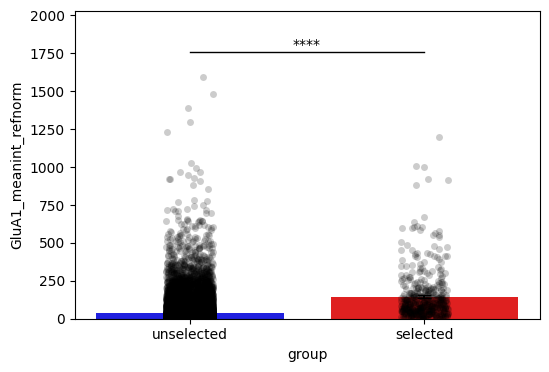

In [57]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ctx.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ctx['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ctx[data_ctx['prot']==prot]
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

## 2. CA1

In [58]:
unadjusted_pvals = []
zscores = []

In [59]:
data['region'].value_counts()

region
HPC    25299
SSC    19975
Name: count, dtype: int64

In [60]:
data_ca1 = data[data['region']=='HPC']

In [61]:
data_ca1.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group
PVGFP-HPC-GluA1-M1-002-01_pp_syn1,0.000007,347.000000,1.402020,1.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn1,GluA1,unselected
PVGFP-HPC-GluA1-M1-002-01_pp_syn2,0.000028,444.695652,9.959104,1.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn2,GluA1,unselected
PVGFP-HPC-GluA1-M1-002-01_pp_syn3,0.000000,0.000000,0.000000,0.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn3,GluA1,unselected
PVGFP-HPC-GluA1-M1-002-01_pp_syn4,0.000011,385.111111,3.787978,1.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn4,GluA1,unselected
PVGFP-HPC-GluA1-M1-002-01_pp_syn5,0.000453,390.869333,141.074110,2.0,0.0,M1,HPC,M1_GluA1_002-01,002-01,syn5,GluA1,unselected


In [62]:
data_ca1['prot'].value_counts()

prot
GluA1    25299
Name: count, dtype: int64

### 2. GluA1

In [63]:
data_ca1_a1 = data_ca1[data_ca1['prot']=='GluA1']

In [64]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a1, groups=data_ca1_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   target_vol 
No. Observations:   25299     Method:               REML       
No. Groups:         20        Scale:                0.0000     
Min. group size:    675       Log-Likelihood:       154411.4443
Max. group size:    1461      Converged:            Yes        
Mean group size:    1265.0                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  38.066 0.000  0.001  0.001
group[T.unselected] -0.001    0.000 -29.448 0.000 -0.001 -0.001
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [65]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.0
1.3414917398519415e-190


In [66]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a1, groups=data_ca1_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  25299   Method:             REML                  
No. Groups:        20      Scale:              13244.7021            
Min. group size:   675     Log-Likelihood:     -155991.0986          
Max. group size:   1461    Converged:          Yes                   
Mean group size:   1265.0                                            
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            192.075    7.278  26.390 0.000  177.810  206.340
group[T.unselected] -114.957    5.359 -21.451 0.000 -125.461 -104.454
Group Var            496.209    1.427                                



In [67]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.7769569811547595e-153
4.444902605073591e-102


#### Compile p-values

In [68]:
pvals_df_index = [
      'GluA1_vol',
    'GluA1_meanint_refnorm'
]

In [69]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [70]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [71]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ca1_selectedvsunselected_lmer_pvals.csv')

In [72]:
prots = unique(data['prot'])

In [73]:
prots

['GluA1']

In [74]:
values = ['target_vol','target_meanint_refnorm']

In [75]:
group_colors = ['blue','red']

In [76]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA1_vol,1.341492e-190,-29.448,2.682983e-190,True
GluA1_meanint_refnorm,4.444903e-102,-21.451,4.444903e-102,True


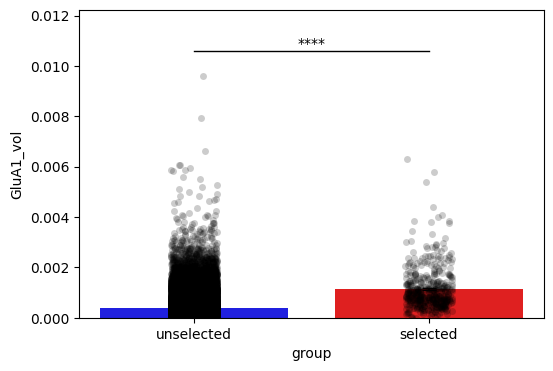

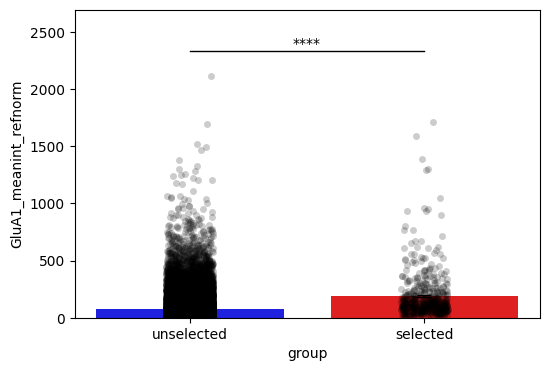

In [77]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Identify numerical columns in 'data_ca1'
numerical_columns = data_ca1.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ca1['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ca1[data_ca1['prot']==prot]
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ca1 points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/CA1_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/CA1_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

In [78]:
data.to_csv('/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/PV_vs_Thy1_combined/PV_GFP_GluA1.csv')